# ETL

Objetivo: El presente notebook tiene como fin examinar los archivos dados y determinar las tablas aproximadas con las que se trabajara, sobretodo evitar tener columnas anidadas

En terminos generales se trabajaran con las siguientes bibliotecas:

In [1]:
import gzip
import json
import pandas as pd
import numpy as np
import ast
import re
import warnings
import nltk

In [2]:
# Desactiva las advertencias temporalmente
warnings.filterwarnings("ignore")

In [ ]:
# Reactiva las advertencias
# warnings.filterwarnings("default")

En el siguiente cuaderno se realizara la primera parte del ETL correspondiente a los archivos proporcionados en el siguiente orden:

1. users_items.json.gz
2. user_reviews.json.gz
3. steam_games.json.gz

### Funciones que usaremos

A continuación estaran las funciones que en terminos generales serviran al desarrollo de los fines del notebook

In [3]:
# Funcion para pasar los archivos a un DataFrame, archivo_to_df(args: archivo con su ruta, line_json o line_ast), tipo line_json si es json standar y tipo line_ast si no lo es
def line_json(linea):
    # Lee la linea como un json
    return json.loads(linea)

def line_ast(linea):
    # Lee la linea evaluandola como objetos python validos
    return ast.literal_eval(linea)

def archivo_to_df(archivo_comprimido_path, process):

    """
    Convierte un archivo comprimido json.gz en DataFrame.

    Parameters:
    - archivo_comprimido_path (str): La ruta al archivo comprimido.
    - process (function): La función de procesamiento a aplicar a cada línea.

    Returns:
    - pd.DataFrame: El DataFrame resultante.
    """
    # Inicializa una lista para almacenar los objetos de cada línea
    datos = []

    # Abre el archivo comprimido y carga los datos en la lista
    with gzip.open(archivo_comprimido_path, 'rt', encoding='utf-8') as archivo_comprimido:
        for linea in archivo_comprimido:
            # Carga el JSON de cada línea segun la función escogida
            objeto = process(linea)
            # Carga la linea procesada a la lista datos
            datos.append(objeto)

    # Convierte la lista datos a un DataFrame
    df = pd.DataFrame(datos)

    return df

In [4]:
# Funciones para eliminar_filas_vacias(args: df) y filas_duplicadas_con_excepcion(args: df, columna excluida que contiene listas, el argumento tiene que ser una lista)
def eliminar_filas_vacias(df):
    # Sumamos las filas vacias
    vacias = df.isnull().all(axis=1).sum()
    print(f'El numero de filas vacias eliminadas es: {vacias}')
    # Eliminamos las filas vacias
    df = df.dropna(how='all').reset_index(drop=True)
    return df

def filas_duplicadas(df):
    # Sumamos las filas duplicadas
    duplicadas = df.duplicated().sum()
    print(f'El numero de filas duplicadas eliminadas es: {duplicadas}')
    # Eliminamos las filas duplicadas
    df = df.drop_duplicates(ignore_index=True)
    return df

def filas_duplicadas_con_excepcion(df, columna_conservar):
    # Sumamos las filas duplicadas
    columnas_validas = df.columns.difference(columna_conservar)
    duplicadas = df.duplicated(subset=columnas_validas).sum()
    print(f'El numero de filas duplicadas eliminadas es: {duplicadas}')
    # Eliminamos las filas duplicadas basándonos en todas las columnas excepto la columna especificada
    df = df.drop_duplicates(subset=columnas_validas, ignore_index=True)
    return df



In [5]:
# Función para ver los elementos de un dataframe en toda su extensión, muestra(args: df, cantidad de elementos a mostrar)
def muestra(df, cantidad):

    # Almacenamos el valor original de max_colwidth
    original_max_colwidth = pd.get_option('display.max_colwidth')
    
    # Establece max_colwidth en None para evitar truncar el contenido
    pd.set_option('display.max_colwidth', None)
    
    # Muestra el DataFrame
    df_muestra = df.sample(n=cantidad)
    print(df_muestra.to_string(index=False)) 
    
    # Restaura el valor original de max_colwidth
    pd.set_option('display.max_colwidth', original_max_colwidth)
    
    return 

In [6]:
# Función para ver la cantidad de elementos nulos por fila, nulos_por_columna(args: df)
def nulos_por_columna(df):
    df = df.isnull().sum()
    return df

In [7]:
# Funcion para ver las filas con un elemento nulo o mas, filas_nulas(args: df, columnas a inspeccionar)
def filas_nulas(df,columnas):
    df_filas_nulas= df.loc[df[columnas].isna()]
    return df_filas_nulas

In [8]:
# Funcion para eliminar las filas con al menos un elemento nulo en la fila, eliminar_filas_con_nulos(args: df, columna a considerar con los elementos nulos)
def eliminar_filas_con_nulos(df, columnas):
    df = df.dropna(subset=[columnas]).reset_index(drop=True)
    return df

In [9]:
# Funcion para convertir tipos de columnas, cambiar_tipo_columna(args: df, columna a cambiar, tipo al cual se cambiara)
def cambiar_tipo_columna(df, columna, tipo):
    df[columna]=df[columna].astype(tipo)
    return df

In [10]:
# Función para guardar los archivos en un csv, df_to_parquet(df, nombre del dataframe)
def df_to_parquet(df, df_name):
    df.to_parquet(f'dataset/{df_name}.parquet', index=False)
    return df

## 1. Tratamiento user_items.json.gz

Abrimos el archivo

In [11]:
# Usamos la función line_ast por la presencia de comillas simples en el json
df_user_items = archivo_to_df('dataset/users_items.json.gz', line_ast)

Inspeccionamos el archivo

In [12]:
df_user_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [13]:
df_muestra = muestra(df_user_items, 5)

              user_id  items_count          steam_id                                             user_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Procedemos a eliminar filas vacias y duplicadas

In [14]:
df_user_items = eliminar_filas_vacias(df_user_items)

El numero de filas vacias eliminadas es: 0


In [15]:
df_user_items = filas_duplicadas_con_excepcion(df_user_items, ['items'])

El numero de filas duplicadas eliminadas es: 684


Verificamos la presencia de elementos nulos por columna

In [16]:
nulos = nulos_por_columna(df_user_items)
nulos

user_id        0
items_count    0
steam_id       0
user_url       0
items          0
dtype: int64

Luego tratamos las columnas steam_id e items_count para convertirlos a un tipo de dato mas adecuado

In [17]:
# Cambiamos steam_id por int64 y a items_count por int 32
df_user_items = cambiar_tipo_columna(df_user_items, 'steam_id', 'int64')
df_user_items = cambiar_tipo_columna(df_user_items, 'items_count', 'int32')

Ahora que eliminamos los valores nulos y duplicados empezaremos a crear dos dataframes para poder tener la columna items mas legible,los dataframes seran user_items y user_items_list

### - user_items

Otra consideración a tener es que al no haber elementos nulos podemos eliminar la columna user_url ya que no la necesitaremos ni para los objetivos a cumplir ni para recuperar datos

Creamos el nuevo dataframe

In [18]:
user_items = df_user_items[['steam_id', 'user_id', 'items_count']]

Inspeccionamos el dataframe

In [19]:
user_items.head()

,steam_id,user_id,items_count
0,76561197970982479,76561197970982479,277
1,76561198035864385,js41637,888
2,76561198007712555,evcentric,137
3,76561197963445855,Riot-Punch,328
4,76561198002099482,doctr,541


Guardamos el dataframe en un archivo con el mismo nombre

In [20]:
user_items = df_to_parquet(user_items, 'user_items')

### - user_items_list

Creamos el nuevo dataframe

In [25]:
user_items_list = df_user_items[['steam_id', 'items']]

Inspeccionamos el dataframe

In [26]:
muestra_user_items_list = muestra(user_items_list, 5)

         steam_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

A continuación escribimos el codigo para desanidar la columna items

In [27]:
# Creamos una lista para almacenar los datos expandidos
expanded_data = []

# Se inicia un bucle que itera a través de cada fila del DataFrame user_items_list.
for index, row in user_items_list.iterrows():
    # Se obtiene la columna 'items' de la fila actual y se almacena en la variable items_list
    items_list = row['items']
    
    # Si la lista de diccionarios en 'items' no está vacía, la expandimos
    if items_list:
        for item_dict in items_list:
            # Creamos un nuevo diccionario basado en la fila original
            new_data = row.to_dict()
            # Añadimos las columnas adicionales a partir de los datos del 'item_dict'
            new_data['item_id'] = item_dict['item_id']
            new_data['item_name'] = item_dict['item_name']
            new_data['playtime_forever'] = item_dict['playtime_forever']
            new_data['playtime_2weeks'] = item_dict['playtime_2weeks']
            # Agregamos el nuevo diccionario a 'expanded_data'
            expanded_data.append(new_data)

# Creamos un nuevo DataFrame a partir de los datos expandidos
user_items_list = pd.DataFrame(expanded_data)

user_items_list.drop('items', axis=1, inplace=True)

Examinamos el resultado

In [28]:
# En este caso simplemente usaremos sample y no llamaremos a la función muestra porque no hay conflictos en la visualización
user_items_list.sample(n=5)

,steam_id,item_id,item_name,playtime_forever,playtime_2weeks
3364224,76561198101528233,264730,Deadly 30,139,0
4349566,76561198048709958,620,Portal 2,1486,0
489602,76561198067193543,339280,Strife,44,0
3470279,76561198175919034,205790,Dota 2 Test,0,0
2223384,76561198067662758,200170,Worms Revolution,1749,0


In [29]:
user_items_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094082 entries, 0 to 5094081
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   steam_id          int64 
 1   item_id           object
 2   item_name         object
 3   playtime_forever  int64 
 4   playtime_2weeks   int64 
dtypes: int64(3), object(2)
memory usage: 194.3+ MB


Luego dados los objetivos para este proyecto la columna playtime_2weeks es redundante por lo que ya no estara presente en el dataframe, item_name tampoco seria necesario puesto que esta estaria presente en steam_games.

In [32]:
user_items_list = user_items_list[['steam_id', 'item_id', 'playtime_forever']]

Verificamos la existencia de valores nulos

In [33]:
nulos_user_items_list = nulos_por_columna(user_items_list)
nulos_user_items_list

steam_id            0
item_id             0
playtime_forever    0
dtype: int64

Convertimos las columnas item_id, playtime_forever y playtime_2weeks aun tipo de dato mas conveniente

In [34]:
# Cambiamos item_id, playtime_forever y playtime_2weeks por tipo int32
user_items_list = cambiar_tipo_columna(user_items_list, 'item_id', 'int32')
user_items_list = cambiar_tipo_columna(user_items_list, 'playtime_forever', 'int32')

Guardamos el archivo

In [35]:
# Guardamos el archivo en un csv con el mismo nombre
user_items_list = df_to_parquet(user_items_list, 'user_items_list')

## 2. Tratamiento user_reviews.json.gz

Abrimos el archivo

In [21]:
# Usamos la función line_ast por la presencia de comillas simples en el json
df_user_reviews = archivo_to_df('dataset/user_reviews.json.gz', line_ast)

Inspeccionamos su información

In [22]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [23]:
muestra_df_user_reviews = muestra(df_user_reviews, 5)

          user_id                                             user_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Eliminamos las filas vacias y duplicadas

In [24]:
# Eliminamos filas vacias
df_user_reviews = eliminar_filas_vacias(df_user_reviews)

El numero de filas vacias eliminadas es: 0


In [25]:
# Eliminamos filas duplicadas, teniendo en cuenta que la columna reviews contiene listas
df_user_reviews = filas_duplicadas_con_excepcion(df_user_reviews, ['reviews'])

El numero de filas duplicadas eliminadas es: 314


Verificamos los nulos por columna

In [26]:
nulos2 = nulos_por_columna(df_user_reviews)
nulos2

user_id     0
user_url    0
reviews     0
dtype: int64

Una vez considerado todo esto empezaremos a solo considerar las columnas user_id y reviews ya que son las que generan importancia, ademas de que no necesitamos recuperar informacion de user_url.

In [27]:
df_user_reviews = df_user_reviews[['user_id', 'reviews']]

Luego observamos que tenemos user_id de un anterior dataframe llamado user_items por lo que relacionaremos ambas columnas y extraeremos la columna steam_id

In [28]:
# Realiza una fusión merge basada en la columna 'user_id' para agregar 'steam_id' a df_user_reviews
df_user_reviews = df_user_reviews.merge(user_items[['user_id', 'steam_id']], on='user_id', how='left')

In [29]:
nulos3 = nulos_por_columna(df_user_reviews)
nulos3

user_id     0
reviews     0
steam_id    4
dtype: int64

Observamos que existen 4 filas que no pudieron encontrar valor en user_items, para este caso las eliminaremos directamente puesto que rellenar información en la tabla presente tambien conllevaria a completar aun mas información en el dataframe user_items.

In [30]:
df_user_reviews = eliminar_filas_con_nulos(df_user_reviews, 'steam_id')

In [31]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25481 entries, 0 to 25480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   25481 non-null  object 
 1   reviews   25481 non-null  object 
 2   steam_id  25481 non-null  float64
dtypes: float64(1), object(2)
memory usage: 597.3+ KB


Convertimos steam_id a tipo int64 para normalizar

In [32]:
df_user_reviews = cambiar_tipo_columna(df_user_reviews, 'steam_id', 'int64')

Luego reordenamos el dataframe considerando solo steam_id y reviews ya que user_id es redundante

In [33]:
df_user_reviews = df_user_reviews[['steam_id', 'reviews']]

In [34]:
muestra_df_user_reviews2 = muestra(df_user_reviews, 5)

         steam_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Observamos un caso similar un anterior dataframe por lo que procederemos de manera similar por lo que primero extraeremos las keys de un elemento para posteriormente basarnos en esta información para poder escribir el codigo.

In [35]:
# Usamos propiedades de ubicación de los diferentes elementos
df_user_reviews['reviews'][0][0].keys()
# df_user_reviews['reviews'][0] hace referencia a la ubicación del elemento en el dataframe que seria una lista, el siguiente [0] representa al primer elemento de la lista
# que es un diccionario, y por ultimo .keys() nos devuelve las llaves de este diccionario

dict_keys(['funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review'])

Usando la información encontrada podemos empezar a escribir el codigo para expandir el dataframe recordando que al no tener comillas dobles no podemos usar funciones pertecientes a json

In [36]:
# Creamos una lista para almacenar los datos expandidos
expanded_data = []

# Iteramos sobre cada fila del DataFrame original ('prueba')
for index, row in df_user_reviews.iterrows():
    # Obtenemos la lista de diccionarios en la columna 'items' de la fila actual
    items_list = row['reviews']
    
    # Si la lista de 'items' está vacía, agregamos la fila original a 'expanded_data'
    if items_list:
        for item_dict in items_list:
            # Creamos un nuevo diccionario basado en la fila original
            new_data = row.to_dict()
            # Añadimos las columnas adicionales a partir de los datos del 'item_dict'
            new_data['funny'] = item_dict['funny']
            new_data['posted'] = item_dict['posted']
            new_data['item_id'] = item_dict['item_id']
            new_data['helpful'] = item_dict['helpful']
            new_data['recommend'] = item_dict['recommend']
            new_data['review'] = item_dict['review']
            # Agregamos el nuevo diccionario a 'expanded_data'
            expanded_data.append(new_data)

# Creamos un nuevo DataFrame a partir de los datos expandidos
user_reviews = pd.DataFrame(expanded_data)

user_reviews.drop('reviews', axis=1, inplace=True)

Ahora buscamos nulos por fila

In [37]:
nulos_user_reviews = nulos_por_columna(user_reviews)
nulos_user_reviews

steam_id     0
funny        0
posted       0
item_id      0
helpful      0
recommend    0
review       0
dtype: int64

Observamos los tipos de columna del dataframe para verificar si se necesitan transformaciones

In [38]:
muestra_user_reviews = muestra(user_reviews, 5)

         steam_id                            funny                    posted item_id                                       helpful  recommend                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [39]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58415 entries, 0 to 58414
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   steam_id   58415 non-null  int64 
 1   funny      58415 non-null  object
 2   posted     58415 non-null  object
 3   item_id    58415 non-null  object
 4   helpful    58415 non-null  object
 5   recommend  58415 non-null  bool  
 6   review     58415 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 2.7+ MB


Cambiamos el tipo de columna de item_id a int32

In [40]:
user_reviews = cambiar_tipo_columna(user_reviews, 'item_id', 'int32')

Luego reordenaremos las columnas para posteriormente solo considerar aquellas columnas con los objetivos solicitados

In [41]:
user_reviews = user_reviews[['steam_id', 'item_id', 'posted', 'recommend', 'review']]

Ahora trataremos con la columna posted ya que la necesitamos en un formato que solo exprese años, para ello extraeremos los años presentes para deducir el año que faltaria y completarlo en los valores NaN

In [42]:
year_counts = user_reviews['posted'].str.extract(r'(\d{4})', expand=False)
year_counts = year_counts.value_counts(dropna=False)
year_counts

posted
2014    21831
2015    18147
NaN      9927
2013     6713
2012     1201
2011      530
2010       66
Name: count, dtype: int64

Como podemos observar tenemos años que van del 2010 al 2015 entonces deducimos que el siguiente valor es 2016 el cual sera el valor asignado para NaN, entonces procedemos a realizar el reemplazo

In [43]:
# Creamos la funcion para extraer el año y reemplazar en caso sea necesario
def extract_year(date_str):
    year_match = re.search(r'\d{4}', date_str)
    if year_match:
        return year_match.group(0)
    return '2016'

user_reviews['posted'] = user_reviews['posted'].apply(extract_year)

Ahora procedemos a cambiar la columna recommend con 0 y 1 correspondientemente para y False y True

In [44]:
user_reviews['recommend'] = user_reviews['recommend'].replace({True: 1, False: 0})
user_reviews['recommend'] = user_reviews['recommend'].astype(int)

Ahora convertiremos las columnas recommend y posted a int32

In [45]:
user_reviews = cambiar_tipo_columna(user_reviews, 'posted', 'int32')
user_reviews = cambiar_tipo_columna(user_reviews, 'recommend', 'int32')

In [46]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58415 entries, 0 to 58414
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   steam_id   58415 non-null  int64 
 1   item_id    58415 non-null  int32 
 2   posted     58415 non-null  int32 
 3   recommend  58415 non-null  int32 
 4   review     58415 non-null  object
dtypes: int32(3), int64(1), object(1)
memory usage: 1.6+ MB


Luego convertimos la columna review a un valor numerico con NLP con la siguiente escala: debe tomar el valor '0' si es malo, '1' si es neutral y '2' si es positivo

Usaremos la biblioteca NLTK para hacer el analisis de sentimiento, adicionalmente implementaremos el modelo VADER que esta diseñado para analizar el sentimiento de textos en redes sociales y similares.

Traemos al modelo VADER

In [ ]:
#nltk.download('vader_lexicon')

Ahora necesitamos que la columna review este en tipo str

In [47]:
user_reviews = cambiar_tipo_columna(user_reviews, 'review', str)

In [48]:
from nltk.sentiment import SentimentIntensityAnalyzer
# Crea una instancia de SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Aplica VADER para obtener la puntuación de polaridad
user_reviews['sentiment_analysis'] = user_reviews['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Mapea los valores de polaridad a la escala deseada
user_reviews['sentiment_analysis'] = user_reviews['sentiment_analysis'].apply(lambda x: 0 if x < 0 else (1 if x == 0 else 2))


In [49]:
muestra_user_reviews2 = muestra(user_reviews, 5)

         steam_id  item_id  posted  recommend                                                                                        review  sentiment_analysis
76561198083611264   270880    2016          1 bought this game and loved it but still some how managed to get ♥♥♥♥ caught in ceiling fan :P                   2
76561198103200144   321360    2015          1                                                 OMFG SO GOOD 11/10 IGN "WOULD PLAY AGAIN"-IGN                   2
76561198069235824   304930    2014          1                                                                               quite fantastic                   2
76561198058532448   212800    2013          1                                            I knew about this game before i saw it on steam :D                   2
76561198078617408     4000    2014          1                                                    all I create in this game would be BARRELS                   2


Reordenamos las Columnas

In [51]:
user_reviews = user_reviews[['steam_id', 'item_id', 'posted', 'recommend', 'sentiment_analysis', 'review']]

In [53]:
user_reviews = cambiar_tipo_columna(user_reviews, 'sentiment_analysis', 'int32')

In [55]:
# Ahora guardamos el archivo
user_reviews = df_to_parquet(user_reviews, 'user_reviews')

## 3. Tratamiento steam_games.json.gz

Abrimos el archivo

In [93]:
# Usamos la función line_json al ser un archivo que sigue el formato json
df_steam_games = archivo_to_df('dataset/steam_games.json.gz', line_json)

Inspeccionamos el contenido

In [94]:
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


In [95]:
muestra_df_steam_games = muestra(df_steam_games, 5)

    publisher             genres                            app_name                               title                                                                        url release_date                                                                      tags                                                               reviews_url                                                                                 specs  price early_access     id            developer
          NaN                NaN                                 NaN                                 NaN                                                                        NaN          NaN                                                                       NaN                                                                       NaN                                                                                   NaN    NaN          NaN    NaN                  NaN
          NaN                NaN                  

Empezamos con la limpieza del dataframe

In [96]:
df_steam_games = eliminar_filas_vacias(df_steam_games)

El numero de filas vacias eliminadas es: 88310


In [97]:
df_steam_games = filas_duplicadas_con_excepcion(df_steam_games, ['genres', 'tags', 'specs'])

El numero de filas duplicadas eliminadas es: 0


Ahora reordenaremos las columnas quitando de por medio las columna early_acces y reviews_url al no tener datos relevantes para los objetivo y tampoco para completar data faltante

In [98]:
df_steam_games = df_steam_games[['id', 'title', 'url', 'app_name', 'genres', 'tags', 'specs', 'developer', 'publisher', 'release_date', 'price']]

Revisamos como esta el dataframe

In [99]:
muestra_df_steam_games2 = muestra(df_steam_games, 5)

    id                              title                                                                         url                           app_name                                                    genres                                                                                                                                  tags                                                                                                       specs         developer       publisher release_date  price
702180                     Mafia is Alive                    http://store.steampowered.com/app/702180/Mafia_is_Alive/                     Mafia is Alive [Casual, Indie, Massively Multiplayer, RPG, Early Access]                          [Early Access, Indie, Casual, RPG, Massively Multiplayer, Survival, Comedy, Funny, Family Friendly, Mystery]                                                     [Multi-player, Online Multi-Player, Steam Achievements]   ZO Studio Games ZO Studio Games   2017

Podemos percatarnos que las columnas id y title ya las conocemos de anteriores dataframes por lo que les cambiaremos el nombre para normalizarlos

In [100]:
df_steam_games = df_steam_games.rename(columns={'id': 'item_id', 'title': 'item_name'})

Ahora buscamos los nulos por columna para poder realizar el cambio de tipos de las columnas

In [101]:
nulos_df_steam_games = nulos_por_columna(df_steam_games)
nulos_df_steam_games

item_id            2
item_name       2050
url                0
app_name           2
genres          3283
tags             163
specs            670
developer       3299
publisher       8052
release_date    2067
price           1377
dtype: int64

Inspeccionamos las columnas que podrian darnos problemas en las columna item_id

In [102]:
filas_nulas_df_steam_games = filas_nulas(df_steam_games, 'item_id')
filas_nulas_df_steam_games

,item_id,item_name,url,app_name,genres,tags,specs,developer,publisher,release_date,price
74,NaN,NaN,http://store.steampowered.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.99
30961,NaN,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]","[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...","Rocksteady Studios,Feral Interactive (Mac)","Warner Bros. Interactive Entertainment, Feral ...",2012-09-07,19.99


Observamos que podemos recupera información en una fila y en otra simplemente tenemos que eliminarla, por lo que procederemos a eliminar la fila 74 y recuperar el id faltante para la otra fila

In [103]:
# Elimina la fila en el índice 74
df_steam_games = df_steam_games.drop(74)

# Restablece el índice
df_steam_games = df_steam_games.reset_index(drop=True)

# Reemplaza los valores NaN por un valor predeterminado
df_steam_games['item_id'].fillna(200260, inplace=True)

Ahora procedemos a cambiar los tipos de datos

In [104]:
df_steam_games = cambiar_tipo_columna(df_steam_games, 'item_id', 'int32')

Ahora divideremos el dataframe en 2 teniendo como enlace la columna item_id para luego poder tratar de mjor manera los datos, los dataframes seran: steam_games y steam_games_genres

### - steam_games

Creamos el primer dataframe steam_games

In [105]:
steam_games = df_steam_games[['item_id', 'item_name', 'app_name', 'developer', 'publisher', 'release_date', 'price']]

Inspeccionamos nuestro dataframe

In [106]:
steam_games.sample(n=5)

,item_id,item_name,app_name,developer,publisher,release_date,price
19792,565510,Borealis,Borealis,NaN,NaN,2016-12-23,4.99
12868,753440,A Small Robot Story,A Small Robot Story,bc likes you,MAGIC Spell Studios,2017-12-19,4.99
6160,452300,The Graduate,The Graduate,NaN,NaN,1998-12-22,3.99
7961,554880,Gase and Aldridge Spotter Audio,Gase and Aldridge Spotter Audio,Monster Games,Dusenberry Martin Racing,2016-11-16,0.99
25098,399660,Battle Battalions,Battle Battalions,Petroglyph,Petroglyph,2015-11-03,Free to Play


In [107]:
nulos_steam_games = nulos_por_columna(steam_games)
nulos_steam_games

item_id            0
item_name       2049
app_name           1
developer       3298
publisher       8051
release_date    2066
price           1377
dtype: int64

Dado que tenemos una gran cantidad de datos vacio procederemos a rellenar las columnas recuperando data

Las columnas item_name y developer son de nuestro interes por lo que las rellenaremos con valores de las columnas app_name y publisher respectivamente

In [108]:
#La columna item_name y developer tienen muchos valores nulos por lo que trataremos de rellenar estos valores con app_name y publisher respectivamente
steam_games.loc[:, 'item_name'] = steam_games['item_name'].fillna(steam_games['app_name'])
steam_games.loc[:, 'developer'] = steam_games['developer'].fillna(steam_games['publisher'])

In [109]:
nulos_steam_games2 = nulos_por_columna(steam_games)
nulos_steam_games2

item_id            0
item_name          1
app_name           1
developer       3233
publisher       8051
release_date    2066
price           1377
dtype: int64

Ahora seguiremos rellenando los datos usando la concatenacion de desconocido con item_id

In [110]:
# Rellena los valores nulos en 'item_name' con la concatenación 'desconocido_' + 'item_id'
steam_games.loc[:, 'item_name'] = steam_games['item_name'].fillna('desconocido_' + steam_games['item_id'].astype(str))
steam_games.loc[:, 'developer'] = steam_games['developer'].fillna('desconocido_' + steam_games['item_id'].astype(str))

In [111]:
nulos_steam_games3 = nulos_por_columna(steam_games)
nulos_steam_games3

item_id            0
item_name          0
app_name           1
developer          0
publisher       8051
release_date    2066
price           1377
dtype: int64

Ahora nos quedamos solo con las columnas de importancia del dataframe y procedemos a guardarlo, la columna release_date y price seran tratadas en el siguiente dataframe

In [112]:
steam_games = steam_games[['item_id', 'item_name', 'developer', 'release_date', 'price']]

Ahora extraeremos los años de release year, primero definiremos una función

In [114]:
# Hacemos la funcion correspondiente para extraer los datos
def extract_and_fill_year(date):
    match = re.search(r'(\d{4})', str(date))
    if match:
        return match.group(1)
    else:
        return None

Luego la aplicamos a la columna

In [115]:
# Aplicamos la función a 'release_date' y almacenamos el resultado en una nueva columna 'release_year'
steam_games['release_year'] = steam_games['release_date'].apply(extract_and_fill_year)

Eliminamos release_date y volvemos a hacer el conteo

In [117]:
steam_games = steam_games.drop('release_date', axis=1)

In [119]:
nulos_steam_games4 = nulos_por_columna(steam_games)
nulos_steam_games4

item_id            0
item_name          0
developer          0
price           1377
release_year    2167
dtype: int64

Rellenaremos los valores nulos en proporción a la distribución de años no nulos.

In [132]:
# Calculamos la distribucion de años
year_distribution = steam_games['release_year'].value_counts()

# Calculamos la proporcion de años con respecto a los valores nulos
total_non_null = steam_games['release_year'].count()
year_proportions = year_distribution / total_non_null

# Rellenamos los valores nulos en proporción a la distribución
def fill_nulls(row):
    if pd.isnull(row['release_year']):
        return year_proportions.sample().index[0]  # Selecciona un año según la distribución
    return row['release_year']

steam_games['release_year'] = steam_games.apply(fill_nulls, axis=1)

Por ultimo trataremos la columna price, primero trataremos los valores atipicos

In [134]:
# Revisamos los tipos de valores atipicos que encontraremos
# Filtra y obtén los valores no float en 'price'
non_float_prices = steam_games[~steam_games['price'].astype(str).str.match(r'^\d+\.\d+$', na=False)]['price'].unique()
non_float_prices

array(['Free To Play', 'Free to Play', nan, 'Free', 'Free Demo',
       'Play for Free!', 'Install Now', 'Play WARMACHINE: Tactics Demo',
       'Free Mod', 'Install Theme', 'Third-party', 'Play Now',
       'Free HITMAN™ Holiday Pack', 'Play the Demo',
       'Starting at $499.00', 'Starting at $449.00', 'Free to Try',
       'Free Movie', 'Free to Use'], dtype=object)

Rellenaremos los valores atipicos en price con 0.0

In [135]:
# Filtra los valores no coincidentes con el patrón y reemplaza con 0.0
steam_games.loc[~steam_games['price'].astype(str).str.match(r'^\d+\.\d+$', na=False), 'price'] = 0.0

Luego convertimos la columna a tipo float

In [136]:
steam_games = cambiar_tipo_columna(steam_games, 'price', float)

Luego rellenaremos los valores nan segun la proporción de datos de price

In [140]:
# Calculamos la distribucion de precios
price_distribution = steam_games['price'].value_counts()

# Calculamos la proporcion de precios con respecto a los valores nulos
total_non_null = steam_games['price'].count()
price_proportions = price_distribution / total_non_null

# Rellenamos los valores nulos en proporción a la distribución
def fill_nulls(row):
    if pd.isnull(row['price']):
        return price_proportions.sample().index[0]  # Selecciona un año según la distribución
    return row['price']

steam_games['price'] = steam_games.apply(fill_nulls, axis=1)

Verificamos los nulos

In [144]:
nulos_steam_games5 = nulos_por_columna(steam_games)
nulos_steam_games5

item_id         0
item_name       0
developer       0
price           0
release_year    0
dtype: int64

Verificamos la info del dataframe

In [146]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32134 entries, 0 to 32133
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       32134 non-null  int32  
 1   item_name     32134 non-null  object 
 2   developer     32134 non-null  object 
 3   price         32134 non-null  float64
 4   release_year  32134 non-null  object 
dtypes: float64(1), int32(1), object(3)
memory usage: 1.1+ MB


Cambiamos release_year  tipo int32

In [147]:
steam_games = cambiar_tipo_columna(steam_games, 'release_year', 'int32')

Guardamos el archivo

In [149]:
steam_games = df_to_parquet(steam_games, 'steam_games')

### - steam_games_genres

Ahora procedemos a crear el segundo dataframe steam_games_genres

In [150]:
steam_games_genres = df_steam_games[['item_id', 'genres', 'tags']]

Ahora observamos su comportamiento

In [152]:
muestra_steam_games_genres = muestra(steam_games_genres, 5)

 item_id                                genres                                                                                                                                                                                                                              tags
  615150 [Adventure, Indie, RPG, Early Access]                                                                                                                                                                 [Early Access, RPG, Indie, Adventure, Turn-Based, Team-Based, 2D]
   38400                                 [RPG]        [RPG, Post-apocalyptic, Classic, Open World, Turn-Based, Isometric, Sci-fi, Singleplayer, Turn-Based Combat, Multiple Endings, Atmospheric, Retro, Adventure, 1990's, 2D, Difficult, Exploration, CRPG, Tactical, Sandbox]
  460920                      [Action, Sports] [Sports, Open World, Multiplayer, Action, Simulation, Atmospheric, Exploration, Great Soundtrack, First-Person, Adventure, Racing, Co-

In [153]:
nulos_steam_games_genres = nulos_por_columna(steam_games_genres)
nulos_steam_games_genres

item_id       0
genres     3282
tags        162
dtype: int64

Observamos una gran cantidad de elementos vacios en genres, por lo que ahora rellenaremos genres con la columna tags, no sin antes observar el comportamiento de ambas columnas

In [154]:
# Definimos la función elements_count para contar la cantidad de elementos que existen en las listas de las columnas
def element_counts(df, column):
    # Utilizamos el método explode para convertir la columna de listas en filas individuales
    exploded_df = df[column].explode()

    # Utilizamos value_counts para contar la frecuencia de cada elemento, incluyendo NaN
    counts_series = exploded_df.value_counts(dropna=False)

    return counts_series

Ahora observaremos los tipos de elementos que encontraremos

In [155]:
# Ahora tenemos la frecuencia con la que aparecen los datos en la columna genres 
counts_genres = element_counts(steam_games_genres, 'genres')

In [156]:
counts_genres.info()

<class 'pandas.core.series.Series'>
Index: 23 entries, Indie to Accounting
Series name: count
Non-Null Count  Dtype
--------------  -----
23 non-null     int64
dtypes: int64(1)
memory usage: 368.0+ bytes


In [157]:
counts_genres

genres
Indie                        15858
Action                       11321
Casual                        8282
Adventure                     8243
Strategy                      6957
Simulation                    6699
RPG                           5479
NaN                           3282
Free to Play                  2031
Early Access                  1462
Sports                        1257
Massively Multiplayer         1108
Racing                        1083
Design &amp; Illustration      460
Utilities                      340
Web Publishing                 268
Animation &amp; Modeling       183
Education                      125
Video Production               116
Software Training              105
Audio Production                93
Photo Editing                   77
Accounting                       7
Name: count, dtype: int64

Realizamos la mismas operación para la columna tags

In [158]:
# Tambien realizamos lo mismo para la columna tags
counts_tags = element_counts(steam_games_genres, 'tags')

In [159]:
counts_tags.info()

<class 'pandas.core.series.Series'>
Index: 340 entries, Indie to Bikes
Series name: count
Non-Null Count  Dtype
--------------  -----
340 non-null    int64
dtypes: int64(1)
memory usage: 5.3+ KB


In [160]:
counts_tags.head(10)

tags
Indie           17620
Action          13005
Adventure        9831
Casual           9739
Simulation       7730
Strategy         7566
RPG              5919
Singleplayer     4346
Free to Play     2406
Multiplayer      2383
Name: count, dtype: int64

Podemos observar que la columna tags tiene una gran cantidad de elementos con los cuales podremos completar la columna genres, no obstante es importante observar que tiene demasiada variedad de elementos, por lo que tendremos que relizar un corte

Convertimos los valores de tags a una lista, importante a tener en cuenta que la lista ya tiene un orden descendente

In [161]:
# Convertimos tags a una lista
tags = list(dict(counts_tags).values())
len(tags)


340

Necesitamos crear un punto de corte para reducir la gran cantidad de datos posibles en la columna tags, para ello evaluaremos que percentil tomaremos como punto de corte

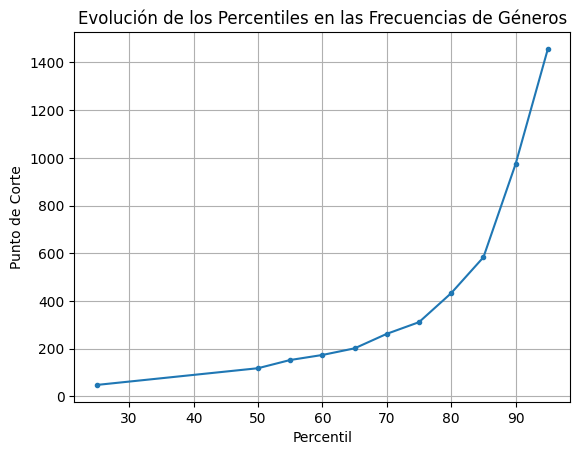

In [162]:
# Importamos la biblioteca matplotlib
import matplotlib.pyplot as plt

# Luego determinamos percentiles de uso comun
percentiles_evaluados = [25,50,55,60,65,70,75,80,85,90,95]
# De ser el caso tambien podemos evaluar todos los valores para una mejor observación
# percentiles_evaluados = np.arange(0, 100, 1)

# Calculamos los valores de los percentiles para cada punto de corte
valores_percentiles = [np.percentile(tags, p) for p in percentiles_evaluados]

# Graficamos la evolución de los percentiles
plt.plot(percentiles_evaluados, valores_percentiles, marker='.')
plt.xlabel('Percentil')
plt.ylabel('Punto de Corte')
plt.title('Evolución de los Percentiles en las Frecuencias de Géneros')
plt.grid(True)
plt.show()

Tomaremos como percentil al 75% al ser un punto medio en el quiebre de la curva, ahora calcularemos la cantidad de elementos pertenecientes en este percentil

In [163]:
# Definimos el percentil 
percentil_deseado = 75

# Calculamos el valor del percentil
punto_corte = np.percentile(tags, percentil_deseado)

# Seleccionamos los generos que están por encima del punto de corte
generos_seleccionados = {genero: frecuencia for genero, frecuencia in dict(counts_tags).items() if frecuencia >= punto_corte}


Revisamos la cantidad de elementos

In [164]:
len(generos_seleccionados)

85

Extraemos los nombres del diccionario que serian las llaves

In [165]:
generos_a_considerar = list(generos_seleccionados.keys())
len(generos_a_considerar)

85

Revisamos una vez mas el estado del dataframe

In [166]:
nulos_steam = nulos_por_columna(steam_games_genres)
nulos_steam

item_id       0
genres     3282
tags        162
dtype: int64

In [167]:
steam_games_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32134 entries, 0 to 32133
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  32134 non-null  int32 
 1   genres   28852 non-null  object
 2   tags     31972 non-null  object
dtypes: int32(1), object(2)
memory usage: 627.7+ KB


Aplicamos el filtro a la columna tags

In [168]:
# Aplica el filtro a la columna 'tags' del DataFrame
steam_games_genres['tags'] = steam_games_genres['tags'].apply(lambda lista: list(set(lista) & set(generos_a_considerar)) if isinstance(lista, list) else lista)


Revisamos ahora la cantidad de elementos que tiene la columna tags para verificar si se hizo el cambio

In [169]:
counts_tags = element_counts(steam_games_genres, 'tags')
len(counts_tags)

86

Juntamos ambas columnas en genres

In [170]:
# Fusiona las listas en la columna 'genres' sin preocuparse por las repeticiones
steam_games_genres['genres'] = steam_games_genres['genres'] + steam_games_genres['tags']

Eliminamos generos duplicados de la columna genres

In [171]:
# Elimina duplicados en cada lista de 'genres'
steam_games_genres['genres'] = steam_games_genres['genres'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)

Borramos la columna tags

In [172]:
steam_games_genres = steam_games_genres.drop(columns=['tags'])

Vemos los elementos nulos NaN presentes

In [173]:
nulos_steam = nulos_por_columna(steam_games_genres)
nulos_steam

item_id       0
genres     3306
dtype: int64

Usamos una función lambda para tratarlos

In [174]:
steam_games_genres['genres'] = steam_games_genres['genres'].apply(lambda x: x if isinstance(x, list) else ['Other'])


In [175]:
nulos_steam = nulos_por_columna(steam_games_genres)
nulos_steam

item_id    0
genres     0
dtype: int64

Verificamos la posible existencia de listas vacias

In [176]:
filas_con_listas_vacias = steam_games_genres[steam_games_genres['genres'].apply(lambda x: isinstance(x, list) and not x)]
filas_con_listas_vacias

,item_id,genres


Observamos el dataframe

In [177]:
steam_games_genres.head()

,item_id,genres
0,761140,"[Simulation, Action, Strategy, Indie, Casual]"
1,643980,"[Fantasy, Free to Play, Tactical, Replay Value..."
2,670290,"[Simulation, Free to Play, Multiplayer, Indie,..."
3,767400,"[Adventure, Action, Casual]"
4,773570,[Other]


Procedemos ha aplicar el MultiLabelBinazer para generas los dummies de genres

In [178]:
from sklearn.preprocessing import MultiLabelBinarizer

# Aplicar MultiLabelBinarizer a la columna 'genres'
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(steam_games_genres['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)

# Agregar las columnas codificadas al DataFrame original
steam_games_genres = pd.concat([steam_games_genres, genres_df], axis=1)
steam_games_genres = steam_games_genres.drop(columns=['genres'])

Observamos el dataframe

In [179]:
steam_games_genres.head()

,item_id,2D,Accounting,Action,Action RPG,Adventure,Animation &amp; Modeling,Anime,Arcade,Atmospheric,...,Tower Defense,Turn-Based,Turn-Based Strategy,Utilities,VR,Video Production,Violent,Visual Novel,Web Publishing,Zombies
0,761140,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,670290,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,767400,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,773570,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Guardamos el archivo resultante

In [180]:
steam_games_genres = df_to_parquet(steam_games_genres, 'steam_games_genres')